In [353]:
#import all required libraries

from dataclasses import dataclass
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

#fix random seed for results reproducibility
random.seed(0)
np.random.seed(0)

#class, which checks if a line segment has mutual points with a given sphere______________________________

@dataclass()
class Point:
    x: float
    y: float
    z: float


@dataclass()
class Sphere(Point):
    R: float


def is_point_belongs_to_sphere(p: Point, s: Sphere):
    return (p.x - s.x) ** 2 + (p.y - s.y) ** 2 + (p.z - s.z) ** 2 - s.R**2

def sphere_intersect_checking(p1: Point, p2: Point, s: Sphere) -> bool:
    f1 = is_point_belongs_to_sphere(p1, s)
    f2 = is_point_belongs_to_sphere(p2, s)
    if p1 == p2:
        return False
    if f1 * f2 <= 0:
        return True
    if f1 + f2 < 0:
        return True
    if f1 + f2 > 0:
        xc = (p1.x + p2.x) / 2
        yc = (p1.y + p2.y) / 2
        zc = (p1.z + p2.z) / 2
        c = Point(xc, yc, zc)
        # print(f"Новая точка {c} left {p1} right {p2}")
        if (c == p1 or c == p2):
            return False
        if f1 > f2:
            return sphere_intersect_checking(c, p2, s)
        else:
            return sphere_intersect_checking(p1, c, s)
    return False
#____________________________________________________________

def distance(ar1, ar2 = [0,0,0]):
    """
    Calculate distance between two points in space
    """
    return ((ar1[0] - ar2[0])**2 + (ar1[1] - ar2[1])**2 + (ar1[2] - ar2[2])**2)**0.5

def first_dir(point):
    """
    Create first move for a given point in source, with a given length
    """
    new_point = point.copy()
    length = np.random.exponential()
    x = random.uniform(-1, 1)
    y = random.uniform(-1, 1)
    z = random.uniform(-1, 1)
    l = distance([x,y,z], [0,0,0])
    new_point[0] += x * (length / l)
    new_point[1] += y * (length / l)
    new_point[2] += z * (length / l)
    return new_point

def calc_omega(point, new_point):
    """
    Calculate cosign direction, given two adjacent tranjectory points
    """
    l = distance(point, new_point)  
    omega = []
    for i in range(3):
        omega.append((new_point[i] - point[i])/l)
    return omega

def create_paths(n_points, sour):
    """
    Create n points in source with their first moves, return list with trajectories
    """
    points = []
    count = 0
    while count < n_points:
        x = random.uniform(0, 0.5)
        y = random.uniform(0, 0.5)
        z = random.uniform(0, 0.5)
        if distance([x,y,z], sour) <= 0.5 and not([x,y,z] in points):
            points.append([x,y,z])
            count += 1
    trajectories = []
    for i in range(0, n_points):
        trajectories.append([[points[i][0]],[points[i][1]],[points[i][2]]])
    
    for i in range(0, n_points):
        point = [trajectories[i][0][0], trajectories[i][1][0], trajectories[i][2][0]]
        new_point = first_dir(point)
        for j in range(3):
            trajectories[i][j].append(new_point[j])
    return trajectories

def scattering(omega):
    """
    Create scattering, given old direction (omega)
    """
    omega_new = omega.copy()
    zenith = random.uniform(-1, 1)
    zenith = np.arccos(zenith)
    azimut = random.uniform(0, 2*np.pi)
    if (omega[2] != 1):
        omega_new[0] = omega[0]*np.cos(zenith) + np.sin(zenith)*(omega[0]*omega[2]*np.cos(azimut) - omega[1]*np.sin(azimut))/((1 - omega[2]**2)**0.5)
        omega_new[1] = omega[1]*np.cos(zenith) + np.sin(zenith)*(omega[1]*omega[2]*np.cos(azimut) + omega[0]*np.sin(azimut))/((1 - omega[2]**2)**0.5)
        omega_new[2] = omega[2]*np.cos(zenith) - ((1 - omega[2]**2)**0.5)*np.sin(zenith)*np.cos(azimut)
    else:
        omega_new[0] = np.sin(zenith)*np.cos(azimut)
        omega_new[1] = np.sin(zenith)*np.sin(azimut)
        omega_new[2] = np.cos(zenith)
    return omega_new

def point(t, particle, n):
    """
    Extract point from list with trajectories (n-th point of particle-th trajectory)
    """
    x = t[particle][0][n]
    y = t[particle][1][n]
    z = t[particle][2][n]
    return [x, y, z]

def path(t, particle):
    """
    Extract path from list with trajectories (particle-th trajectory)
    """
    p = [[],[],[]]
    for i in range(len(t[particle][0])):
        p[0].append(t[particle][0][i])
        p[1].append(t[particle][1][i])
        p[2].append(t[particle][2][i])
    return p

def write_path(p, t):
    """
    Write a trajectory into list of trajectories
    """
    t.append(p)
    return t

def copy_path(t, particle, n):
    """
    Copy particle-th trajectory into end of list of trajectories for n times
    """
    for i in range(n):
        p = path(t, particle)
        t = write_path(p, t)
    return t

def write_omega(t, particle, omega):
    t[particle][0].append(omega[0])
    t[particle][1].append(omega[1])
    t[particle][2].append(omega[2])
    return t
    
def sum_s(a):
    """
    Calculate sum of squares of coordinates (used to check validity of scattering)
    """
    m = 0
    for i in range(3):
        m += a[i]**2
    return m

def roulette(a0, a1, pogl):
    """
    Function which calculates score on each iteration. Based on this score we can kill / split a particle in Darwin algorythm.
    """
    l0 = distance(a0, pogl)
    l1 = distance(a1, pogl)
    f0 = np.exp(-lambd*l0) / (l0**2)
    f1 = np.exp(-lambd*l1) / (l1**2)
    score = f1/f0
    return score

def get_darwin_estimate(n_points, pogl_distance_min, pogl_distance_max):
    """
    Run Darwin algorythm with n_points of points, given limits on minimal and maximal distance between source and absorber
    """
    total = dict()
    total['Start_time'] = datetime.now()
    total['paths'] = []
    sour = [0, 0, 0]
    pogl = [0, 0, 0]
    while not(distance(sour, pogl) >= pogl_distance_min and distance(sour, pogl) <= pogl_distance_max):
        for i in range(0,3):
            pogl[i] = random.uniform(0, pogl_distance_max)
    s = Sphere(pogl[0], pogl[1], pogl[2], 0.5)
    total['pogl'] = pogl
    t = create_paths(n_points, sour)
    omegas = []
    for i in range(len(t)):
        cur_p = point(t, i, 1)
        last_p = point(t, i, 0)
        omegas.append(calc_omega(last_p, cur_p))
        
    weights = [1 for i in range(n_points)]
    is_alive = [1 for i in range(n_points)]
    count = 0
    n_iter = 2
    lambd = 1
    while sum(1 for i in is_alive if i == 1)  != 0:
        for i in range(len(t)):
            if is_alive[i] == 1:
                point1 = point(t, i, n_iter - 1)
                point2 = point(t, i, n_iter - 2)
                p1 = Point(point1[0], point1[1], point1[2])
                p2 = Point(point2[0], point2[1], point2[2])
                if sphere_intersect_checking(p1, p2, s) == True:
                    count += weights[i]
                    is_alive[i] = 2
                    total['paths'].append(t[i])
                    if len(t[i][0]) not in total.keys():
                        total[len(t[i][0])] = [[weights[i] / n_points],[datetime.now()]]
                    else:
                        total[len(t[i][0])][0].append(weights[i] / n_points)
                        total[len(t[i][0])][1].append(datetime.now())
                else: 
                    score = roulette(point2, point1, pogl)
                    #weights[i] *= 1/score
                    if score >= 2:
                        c = int(score)
                        for j in range(c):
                            t = copy_path(t, i, 1)
                            weights.append(weights[i] / c)
                            is_alive.append(1)
                            omegas.append(omegas[i])
                        is_alive[i] = -1
                    elif score < 1:
                        prob = random.uniform(0, 1)
                        if (prob <= 1 - score):
                            is_alive[i] = 0
                        else:
                            weights[i] *= 1/score

        for i in range(len(t)):
            if is_alive[i] == 1:
                old_point = point(t, i, n_iter - 1)
                omegas[i] = scattering(omegas[i])
                length = np.random.exponential()
                new_point = old_point.copy()
                for j in range(3):
                    new_point[j] = old_point[j] + length * omegas[i][j]
                t = write_omega(t, i, new_point)

        n_iter += 1
        
    total['Finish_time'] = datetime.now()
    plot_paths(total['paths'], total['pogl'])
    return total
    """
    Structure of returned dictionary - total:
    Start_time - time of function launch: datetime object
    Finish_time - time of function end (excluding plotting of paths): datetime object
    pogl - coordinates of Absorber: [x, y, z]
    paths - array with paths: [[[x00, x01, ...], [y00, y01, ...], [z00, z01, ...]], [[x10, x11, ...], [y10, y11, ...], [...]], ...]
    *number* of int type - object of type: [[weight0, weight1, ...],[time0, time1, ...]] of points, which achieved Absorber in *number* steps
    """

def create_paths_lamark(n_paths, path_length, pogl):
    """
    Create n_paths of successful paths with a given path_length and absorber coordinates (pogl)
    """
    sour = [0, 0, 0]
    #pogl = [0, 0, 0]
    gotto = 0
    s = Sphere(pogl[0], pogl[1], pogl[2], 0.5)

    paths = []

    while gotto < n_paths:
        t = create_paths(1, sour)
        omegas = []
        for i in range(len(t)):
            cur_p = point(t, i, 1)
            last_p = point(t, i, 0)
            omegas.append(calc_omega(last_p, cur_p))
        lambd = 1
        is_alive = 1
        n_iter = 2
        while is_alive == 1:
            point1 = point(t, 0, n_iter - 1)
            point2 = point(t, 0, n_iter - 2)
            p1 = Point(point1[0], point1[1], point1[2])
            p2 = Point(point2[0], point2[1], point2[2])
            if sphere_intersect_checking(p1, p2, s) == True:
                is_alive = 2
                paths.append(path(t, 0))
                gotto += 1
            else: 
                score = roulette(point2, point1, pogl)
                if score < 1:
                    prob = random.uniform(0, 1)
                    if (prob <= 1 - score):
                        is_alive = 0


            if is_alive == 1:
                old_point = point(t, 0, n_iter - 1)
                omegas[i] = scattering(omegas[i])
                length = np.random.exponential()
                new_point = old_point.copy()
                for j in range(3):
                    new_point[j] = old_point[j] + length * omegas[i][j]
                t = write_omega(t, 0, new_point)

            n_iter += 1

    return paths

def get_lamark_estimate(darwin_results, n_paths, pogl_distance_min, pogl_distance_max):
    """
    Get lamark estimates, given Darwin results
    """
    #n_trials = 10
    summary = dict()
    summary['Start_time'] = datetime.now()
    #new_paths = []
    pogl = [0, 0, 0]
    while not(distance(sour, pogl) >= pogl_distance_min and distance(sour, pogl) <= pogl_distance_max):
        for i in range(0,3):
            pogl[i] = random.uniform(0, pogl_distance_max)
    allpaths = create_paths_lamark(n_paths, path_length, pogl)
    for key in darwin_results.keys():
        if type(key) == int:
            summary[key] = [[],[],[datetime.now()]]
            paths = []
            for i in range(n_paths):
                if len(allpaths[i][0]) == key:
                    paths.append(allpaths[i])
            if len(paths) == 0:
                next 
            n_trials = len(darwin_results[key][0])
            count = 0
            numb = 0
            for i in range(n_trials):
                x = random.uniform(0, 0.5)
                y = random.uniform(0, 0.5)
                z = random.uniform(0, 0.5)
                is_alive = 1
                weight = 1
                n_iter = 1
                while distance([x,y,z], sour) <= 0.5:
                    x = random.uniform(0, 0.5)
                    y = random.uniform(0, 0.5)
                    z = random.uniform(0, 0.5)
                    #probas = [0 for i in range(len(paths))]
                curp = [x,y,z]
                while is_alive == 1: 
                    weights = []
                    for j in range(len(paths)):
                        if len(paths[j][0]) > n_iter:
                            newp = point(paths, j, n_iter)
                            weights.append(distance(curp, newp) ** (-2))
                        else: 
                            weights.append(0)
                    #if sum(weights) == 0:
                        #print("Break")
                     #   break
                    probas = [x / sum(weights) for x in weights]
                    population = list(np.arange(0, len(probas)))
                    nn = random.choices(population, probas)[0]
                    weight *= probas[nn]
                    newp = point(paths, nn, n_iter)
                    #p1 = Point(curp[0], curp[1], curp[2])
                    #p2 = Point(newp[0], newp[1], newp[2])
                    if len(paths[nn][0]) == n_iter + 1:
                        #print("Iteration: ", n_iter, " probabilty: ", weight)
                        count += weight
                        is_alive = 2
                        numb += 1
                        break
                    else: 
                        curp = point(paths, nn, n_iter)

                    n_iter += 1

                summary[key][0].append(weight)
                t = datetime.now()
                summary[key][1].append(t)
                summary[key][2].append(t)
    summary['Finish_time'] = datetime.now()
    return summary
    #print("Sum of weights: ", count)    
    #print("Number of particles achieved: ", numb)    
  
def get_lamark_estimate_v2(darwin_results):
    """
    Get lamark estimates, given Darwin results
    """
    #n_trials = 10
    summary = dict()
    summary['Start_time'] = datetime.now()
    #new_paths = []
    #pogl = [0, 0, 0]
    pogl = darwin_results['paths']
    #while not(distance(sour, pogl) >= pogl_distance_min and distance(sour, pogl) <= pogl_distance_max):
    #    for i in range(0,3):
    #        pogl[i] = random.uniform(0, pogl_distance_max)
    #allpaths = create_paths_lamark(n_paths, path_length, pogl)
    allpaths = darwin_results['paths']
    for key in darwin_results.keys():
        if type(key) == int:
            summary[key] = [[],[],[datetime.now()]]
            paths = []
            for i in range(len(allpaths)):
                if len(allpaths[i][0]) == key:
                    paths.append(allpaths[i])
            if len(paths) == 0:
                next 
            n_trials = len(darwin_results[key][0])
            count = 0
            numb = 0
            for i in range(n_trials):
                x = random.uniform(0, 0.5)
                y = random.uniform(0, 0.5)
                z = random.uniform(0, 0.5)
                is_alive = 1
                weight = 1
                n_iter = 1
                while distance([x,y,z], sour) <= 0.5:
                    x = random.uniform(0, 0.5)
                    y = random.uniform(0, 0.5)
                    z = random.uniform(0, 0.5)
                    #probas = [0 for i in range(len(paths))]
                curp = [x,y,z]
                while is_alive == 1: 
                    weights = []
                    for j in range(len(paths)):
                        if len(paths[j][0]) > n_iter:
                            newp = point(paths, j, n_iter)
                            weights.append(distance(curp, newp) ** (-2))
                        else: 
                            weights.append(0)
                    #if sum(weights) == 0:
                        #print("Break")
                     #   break
                    probas = [x / sum(weights) for x in weights]
                    population = list(np.arange(0, len(probas)))
                    nn = random.choices(population, probas)[0]
                    weight *= probas[nn]
                    newp = point(paths, nn, n_iter)
                    #p1 = Point(curp[0], curp[1], curp[2])
                    #p2 = Point(newp[0], newp[1], newp[2])
                    if len(paths[nn][0]) == n_iter + 1:
                        #print("Iteration: ", n_iter, " probabilty: ", weight)
                        count += weight
                        is_alive = 2
                        numb += 1
                        break
                    else: 
                        curp = point(paths, nn, n_iter)

                    n_iter += 1

                summary[key][0].append(weight)
                t = datetime.now()
                summary[key][1].append(t)
                summary[key][2].append(t)
    summary['Finish_time'] = datetime.now()
    return summary
    """
    Structure of returned dictionary - summary:
    Start_time - time of function launch: datetime object
    Finish_time - time of function end (excluding plotting of paths): datetime object
    *number* of int type - object of type: [[weight0, weight1, ...],[time0, time1, ...]] of points, which achieved Absorber in *number* steps
    """
    
def plot_paths(t, pogl):
    """
    Supportive function which plots paths of particles in 3D space, given array of paths and Absorber coordinates (pogl)
    """
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    N=50
    stride=1
    u = np.linspace(0, 2 * np.pi, N)
    v = np.linspace(0, np.pi, N)
    x = np.outer(np.cos(u), np.sin(v)) * 0.5
    y = np.outer(np.sin(u), np.sin(v)) * 0.5
    z = np.outer(np.ones(np.size(u)), np.cos(v)) * 0.5 
    ax.plot_surface(x, y, z, linewidth=0.0, cstride=stride, rstride=stride, color = 'b')

    u = np.linspace(0, 2 * np.pi, N)
    v = np.linspace(0, np.pi, N)
    x = np.outer(np.cos(u), np.sin(v)) * 0.5 + pogl[0]
    y = np.outer(np.sin(u), np.sin(v)) * 0.5 + pogl[1]
    z = np.outer(np.ones(np.size(u)), np.cos(v)) * 0.5 + pogl[2] 
    ax.plot_surface(x, y, z, linewidth=0.0, cstride=stride, rstride=stride, alpha = 1, color = 'r')

    for i in range(len(t)):
        #if is_alive[i] == 2:
        if i % 10 == 1:
            p = path(t, i)
            ax.plot(p[0], p[1], p[2], color="grey", alpha = 0.2)

    plt.show()

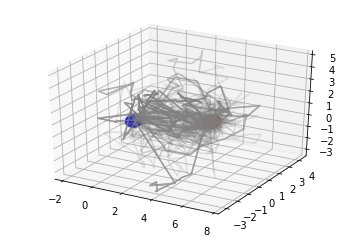

In [351]:
a = get_darwin_estimate(500, 5, 6)

In [354]:
b = get_lamark_estimate_v2(a)